In [1]:
import gdown
file_id = '17_boNLEhV6G0jwANXgjm6FClGLoMYmYI'
output = 'blob'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

In [2]:
import zipfile
zip_file_path = "blob"
extract_to_directory = "extracted_files"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)
print("Extraction complete.")

In [3]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    for data in dataloader:
        pass
    t2 = time.time()
    return t2 - t1

In [4]:
import csv
import numpy as np

class CustomDataset:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))
                dataset.append((image, label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

csv_train_path = 'extracted_files/mnist_train.csv'
csv_test_path = 'extracted_files/mnist_test.csv'
custom_dataset = CustomDataset(csv_train_path)
test_data_custom = CustomDataset(csv_test_path)

In [5]:
# Splitting the train dataset into train and validation datasets

from sklearn.model_selection import train_test_split
train_data_custom, val_data_custom = train_test_split(custom_dataset, test_size=0.1, random_state=42)


In [6]:
print("Total length of training set in csv file:",len(custom_dataset))

print("Length of training set after splitting:",len(train_data_custom))
print("Length of validation set after splitting:",len(val_data_custom))
print("Total length of test set in csv file:",len(test_data_custom))

# Access a sample from the dataset
sample_image, sample_label = custom_dataset[0]
print(f"Label: {sample_label}, Image Shape: {sample_image.shape}")

Total length of training set in csv file: 60000
Length of training set after splitting: 54000
Length of validation set after splitting: 6000
Total length of test set in csv file: 10000
Label: 5, Image Shape: (28, 28)


Now we will construct the custom dataloader from scratch

In [7]:
class CustomDataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.indices):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.dataset[i] for i in batch_indices]

        self.current_index += self.batch_size

        images, labels = zip(*batch_data)
        return np.array(images), np.array(labels)


In [8]:
batch_sizes = [128, 256, 512, 1024]

In [9]:
# Getting loading times for Scratch Implementation for all batch sizes

custom_time=[]
for i in batch_sizes:
    custom_dataloader = CustomDataLoader(custom_dataset, i)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

Now we will do the Pytorch Implementation

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TorchDataset(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = self.load_dataset()

    def load_dataset(self):
        dataset = []
        with open(self.csv_file, 'r') as file:
            csv_reader = csv.reader(file)
            header = next(csv_reader)
            for row in csv_reader:
                label = int(row[0])
                pixel_values = np.array([int(value) for value in row[1:]], dtype=np.uint8)
                image = pixel_values.reshape((28, 28))
                dataset.append((torch.tensor(image, dtype=torch.float32), label))
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = image.unsqueeze(0)
        return image, label

csv_file_path = 'extracted_files/mnist_train.csv'
torch_dataset = TorchDataset(csv_file_path)

transform = transforms.Compose([
    transforms.ToTensor()
])
input_data = np.random.randn(700, 28, 28)
label_data = np.random.randint(0, 10, size=(700,))

In [11]:
# Getting loading times for Pytorch Implementation for all batch sizes

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=torch_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    print(duration)
    torch_time.append(duration)

0.3338429927825928
0.3134300708770752
0.2967562675476074
0.2936725616455078


In [12]:
print("Loading Times obtained for Pytorch Implementation: ",torch_time)
print("Loading Times obtained for Scratch Implementation: ",custom_time)

Loading Times obtained for Pytorch Implementation:  [0.3338429927825928, 0.3134300708770752, 0.2967562675476074, 0.2936725616455078]
Loading Times obtained for Scratch Implementation:  [0.08990693092346191, 0.08895587921142578, 0.09604048728942871, 0.0858914852142334]


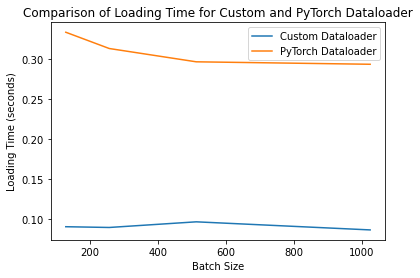

In [13]:
import matplotlib.pyplot as plt
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

We can see from the above graphs that the Custom Dataloader takes less loading time than pytorch implementation. So for the next steps, we will choose the Custom dataset and dataloader having Batch Size- 512

Now we will Implement the Feed forward Neural Network using Pytorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = FeedForward()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
num_epochs = 60

In [15]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

Training the network and getting training, validation and test loss and accuracy

In [16]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)
    

Epoch [1/60], Loss: 2.267141819000244
Epoch 0, Accuracy on Training Set: 0.146

Epoch [1/60], Validation Loss: 2.2557923793792725
Epoch 0, Accuracy on Validation Set: 0.1605

Epoch [1/60], Test Loss: 2.1931631565093994
Epoch 0, Accuracy on Test Set: 0.1667
Epoch [2/60], Loss: 2.069878339767456
Epoch 1, Accuracy on Training Set: 0.19005555555555556

Epoch [2/60], Validation Loss: 2.0754356384277344
Epoch 1, Accuracy on Validation Set: 0.22683333333333333

Epoch [2/60], Test Loss: 2.0589613914489746
Epoch 1, Accuracy on Test Set: 0.2344
Epoch [3/60], Loss: 1.8718321323394775
Epoch 2, Accuracy on Training Set: 0.2770185185185185

Epoch [3/60], Validation Loss: 1.8689510822296143
Epoch 2, Accuracy on Validation Set: 0.32766666666666666

Epoch [3/60], Test Loss: 1.855031967163086
Epoch 2, Accuracy on Test Set: 0.3285
Epoch [4/60], Loss: 1.6061935424804688
Epoch 3, Accuracy on Training Set: 0.3741851851851852

Epoch [4/60], Validation Loss: 1.64768385887146
Epoch 3, Accuracy on Validation Se

Plotting the training vs validation vs test loss

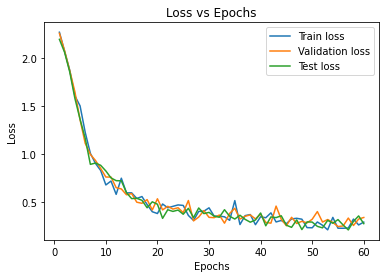

In [17]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Plotting the training vs validation vs test accuracy

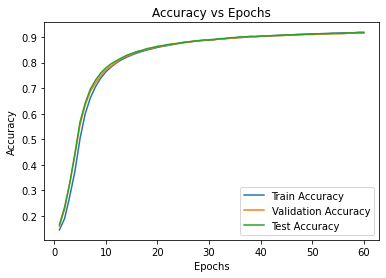

In [18]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now I will change the Activation function from Relu to Sigmoid

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardSigmoid(nn.Module):
    def __init__(self):
        super(FeedForwardSigmoid, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

model_sigmoid = FeedForwardSigmoid()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.0003)
num_epochs = 60

In [20]:
epoch_list=list(range(1, 61))

train_loss_list=[]
validation_loss_list=[]
test_loss_list=[]

train_accuracy_list=[]
validation_accuracy_list=[]
test_accuracy_list=[]

In [21]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    custom_dataloader = CustomDataLoader(train_data_custom, 512)
    for inputs, labels in custom_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        optimizer.zero_grad()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    train_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Training Set: {accuracy}')
    train_accuracy_list.append(accuracy)
    print()


    # Getting validation loss and accuracy
    total_correct = 0
    total_samples = 0

    validation_dataloader = CustomDataLoader(val_data_custom, 512)
    for inputs, labels in validation_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {loss.item()}')
    validation_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Validation Set: {accuracy}')
    validation_accuracy_list.append(accuracy)
    print()

    # Getting test loss and accuracy
    total_correct = 0
    total_samples = 0

    test_dataloader = CustomDataLoader(test_data_custom, 512)
    for inputs, labels in test_dataloader:
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        outputs = model_sigmoid(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {loss.item()}')
    test_loss_list.append(loss.item())
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch}, Accuracy on Test Set: {accuracy}')
    test_accuracy_list.append(accuracy)

Epoch [1/60], Loss: 2.3790581226348877
Epoch 0, Accuracy on Training Set: 0.11274074074074074

Epoch [1/60], Validation Loss: 2.3798739910125732
Epoch 0, Accuracy on Validation Set: 0.109

Epoch [1/60], Test Loss: 2.359358072280884
Epoch 0, Accuracy on Test Set: 0.1135
Epoch [2/60], Loss: 2.3817317485809326
Epoch 1, Accuracy on Training Set: 0.11274074074074074

Epoch [2/60], Validation Loss: 2.3415873050689697
Epoch 1, Accuracy on Validation Set: 0.109

Epoch [2/60], Test Loss: 2.366262674331665
Epoch 1, Accuracy on Test Set: 0.1135
Epoch [3/60], Loss: 2.3281478881835938
Epoch 2, Accuracy on Training Set: 0.11274074074074074

Epoch [3/60], Validation Loss: 2.3382773399353027
Epoch 2, Accuracy on Validation Set: 0.109

Epoch [3/60], Test Loss: 2.3621459007263184
Epoch 2, Accuracy on Test Set: 0.1135
Epoch [4/60], Loss: 2.3114702701568604
Epoch 3, Accuracy on Training Set: 0.11274074074074074

Epoch [4/60], Validation Loss: 2.3425610065460205
Epoch 3, Accuracy on Validation Set: 0.109



Now we will plot Loss curve vs epochs with the sigmoid activation function

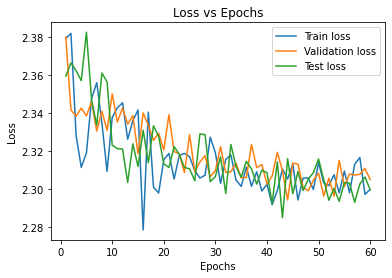

In [22]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, validation_loss_list, label='Validation loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Now we will plot the accuracy vs epochs for the sigmoid activation function

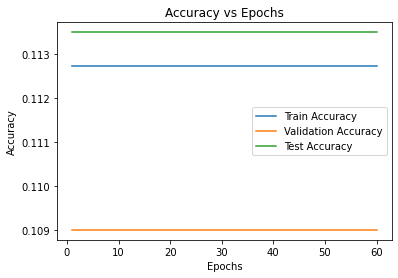

In [23]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, validation_accuracy_list, label='Validation Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Now we will construct the Feed forward Neural Network from Scratch.

In [24]:
import numpy as np

class CustomFeedForwardNN:
    def __init__(self):
        # This contains 5 set of weights and biases as it contains 4 hidden layers. Notice that this netowkr contains 64 neurons instead of 32 neurons. This was giving better accuracy for me.
        self.weights = {
            'fc1': np.random.randn(28 * 28, 64),
            'fc2': np.random.randn(64, 64),
            'fc3': np.random.randn(64, 64),
            'fc4': np.random.randn(64, 64),
            'fc5': np.random.randn(64, 10)
        }

        self.biases = {
            'fc1': np.zeros((1, 64)),
            'fc2': np.zeros((1, 64)),
            'fc3': np.zeros((1, 64)),
            'fc4': np.zeros((1, 64)),
            'fc5': np.zeros((1, 10))
        }

        self.layer_outputs = {}

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        self.layer_outputs['fc0'] = x
        x = self.relu(np.dot(x, self.weights['fc1']) + self.biases['fc1'])
        self.layer_outputs['fc1'] = x
        x = self.relu(np.dot(x, self.weights['fc2']) + self.biases['fc2'])
        self.layer_outputs['fc2'] = x
        x = self.relu(np.dot(x, self.weights['fc3']) + self.biases['fc3'])
        self.layer_outputs['fc3'] = x
        x = self.relu(np.dot(x, self.weights['fc4']) + self.biases['fc4'])
        self.layer_outputs['fc4'] = x
        x = np.dot(x, self.weights['fc5']) + self.biases['fc5']
        self.layer_outputs['fc5'] = x
        return x

# Relu function for 3rd question
    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true, epsilon=1e-15):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true, learning_rate):
        m = x.shape[0]
        loss = self.cross_entropy_loss(self.softmax(self.layer_outputs['fc5']), y_true)
        d_fc5 = self.softmax(self.layer_outputs['fc5'])
        d_fc5[range(m), y_true.argmax(axis=1)] -= 1
        d_fc5 /= m

        d_fc4 = np.dot(d_fc5, self.weights['fc5'].T)
        d_fc4[self.layer_outputs['fc4'] <= 0] = 0

        d_fc3 = np.dot(d_fc4, self.weights['fc4'].T)
        d_fc3[self.layer_outputs['fc3'] <= 0] = 0

        d_fc2 = np.dot(d_fc3, self.weights['fc3'].T)
        d_fc2[self.layer_outputs['fc2'] <= 0] = 0

        d_fc1 = np.dot(d_fc2, self.weights['fc2'].T)
        d_fc1[self.layer_outputs['fc1'] <= 0] = 0

        # Updating weights
        self.weights['fc5'] -= learning_rate * np.dot(self.layer_outputs['fc4'].T, d_fc5)
        self.biases['fc5'] -= learning_rate * np.sum(d_fc5, axis=0, keepdims=True)

        self.weights['fc4'] -= learning_rate * np.dot(self.layer_outputs['fc3'].T, d_fc4)
        self.biases['fc4'] -= learning_rate * np.sum(d_fc4, axis=0, keepdims=True)

        self.weights['fc3'] -= learning_rate * np.dot(self.layer_outputs['fc2'].T, d_fc3)
        self.biases['fc3'] -= learning_rate * np.sum(d_fc3, axis=0, keepdims=True)

        self.weights['fc2'] -= learning_rate * np.dot(self.layer_outputs['fc1'].T, d_fc2)
        self.biases['fc2'] -= learning_rate * np.sum(d_fc2, axis=0, keepdims=True)

        self.weights['fc1'] -= learning_rate * np.dot(self.layer_outputs['fc0'].T, d_fc1)
        self.biases['fc1'] -= learning_rate * np.sum(d_fc1, axis=0, keepdims=True)

        return loss

In [25]:
train_accuracy_list = []
train_loss_list = []
one_hot_labels = np.eye(10)[label_data]

custom_model = CustomFeedForwardNN()
num_epochs = 60
learning_rate = 0.0003

for epoch in range(num_epochs):
    output = custom_model.forward(input_data)

    loss = custom_model.backward(input_data, one_hot_labels, learning_rate)
    acc = np.mean(np.argmax(custom_model.softmax(output), axis=1) == label_data)

    print("Accuracy: ", acc)
    train_accuracy_list.append(acc)

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss}')
    train_loss_list.append(loss)
    print()

Accuracy:  0.10285714285714286
Epoch [0/60], Loss: 30.98621653714844

Accuracy:  0.09857142857142857
Epoch [1/60], Loss: 31.13423986455519

Accuracy:  0.10428571428571429
Epoch [2/60], Loss: 30.936875428012854

Accuracy:  0.12571428571428572
Epoch [3/60], Loss: 30.155361481697994

Accuracy:  0.1457142857142857
Epoch [4/60], Loss: 29.495592259444074

Accuracy:  0.15857142857142856
Epoch [5/60], Loss: 29.061913280860562

Accuracy:  0.16857142857142857
Epoch [6/60], Loss: 28.60751371863529

Accuracy:  0.17714285714285713
Epoch [7/60], Loss: 28.384633708263962

Accuracy:  0.18714285714285714
Epoch [8/60], Loss: 27.996495965835866

Accuracy:  0.1957142857142857
Epoch [9/60], Loss: 27.755756332625065

Accuracy:  0.2042857142857143
Epoch [10/60], Loss: 27.483086275584032

Accuracy:  0.21714285714285714
Epoch [11/60], Loss: 26.865384317824162

Accuracy:  0.22
Epoch [12/60], Loss: 26.868723995825576

Accuracy:  0.24285714285714285
Epoch [13/60], Loss: 26.026499759591903

Accuracy:  0.2242857142

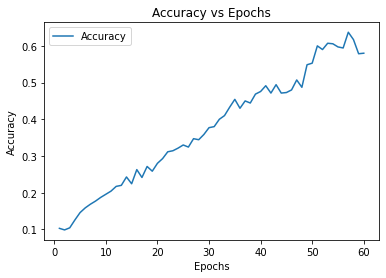

In [26]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

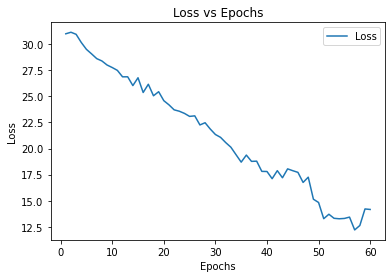

In [27]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

Now we will implement the Scratch Neural Network with Sigmoid activation function instead of Relu function for 4th question

In [28]:
import numpy as np

class CustomFeedForwardNN_Sigmoid:
    def __init__(self):
        self.weights = {
            'fc1': np.random.randn(28 * 28, 64),
            'fc2': np.random.randn(64, 64),
            'fc3': np.random.randn(64, 64),
            'fc4': np.random.randn(64, 64),
            'fc5': np.random.randn(64, 10)
        }

        self.biases = {
            'fc1': np.zeros((1, 64)),
            'fc2': np.zeros((1, 64)),
            'fc3': np.zeros((1, 64)),
            'fc4': np.zeros((1, 64)),
            'fc5': np.zeros((1, 10))
        }

        self.layer_outputs = {}

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        self.layer_outputs['fc0'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc1']) + self.biases['fc1'])
        self.layer_outputs['fc1'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc2']) + self.biases['fc2'])
        self.layer_outputs['fc2'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc3']) + self.biases['fc3'])
        self.layer_outputs['fc3'] = x
        x = self.sigmoid(np.dot(x, self.weights['fc4']) + self.biases['fc4'])
        self.layer_outputs['fc4'] = x
        x = np.dot(x, self.weights['fc5']) + self.biases['fc5']
        self.layer_outputs['fc5'] = x
        return x
    
    # Relu function for 3rd question
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true, epsilon=1e-15):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true, learning_rate):
        m = x.shape[0]

        loss = self.cross_entropy_loss(self.softmax(self.layer_outputs['fc5']), y_true)

        d_fc5 = self.softmax(self.layer_outputs['fc5'])
        d_fc5[range(m), y_true.argmax(axis=1)] -= 1
        d_fc5 /= m

        d_fc4 = np.dot(d_fc5, self.weights['fc5'].T)
        d_fc4[self.layer_outputs['fc4'] <= 0] = 0

        d_fc3 = np.dot(d_fc4, self.weights['fc4'].T)
        d_fc3[self.layer_outputs['fc3'] <= 0] = 0

        d_fc2 = np.dot(d_fc3, self.weights['fc3'].T)
        d_fc2[self.layer_outputs['fc2'] <= 0] = 0

        d_fc1 = np.dot(d_fc2, self.weights['fc2'].T)
        d_fc1[self.layer_outputs['fc1'] <= 0] = 0

        # Updating weights
        self.weights['fc5'] -= learning_rate * np.dot(self.layer_outputs['fc4'].T, d_fc5)
        self.biases['fc5'] -= learning_rate * np.sum(d_fc5, axis=0, keepdims=True)

        self.weights['fc4'] -= learning_rate * np.dot(self.layer_outputs['fc3'].T, d_fc4)
        self.biases['fc4'] -= learning_rate * np.sum(d_fc4, axis=0, keepdims=True)

        self.weights['fc3'] -= learning_rate * np.dot(self.layer_outputs['fc2'].T, d_fc3)
        self.biases['fc3'] -= learning_rate * np.sum(d_fc3, axis=0, keepdims=True)

        self.weights['fc2'] -= learning_rate * np.dot(self.layer_outputs['fc1'].T, d_fc2)
        self.biases['fc2'] -= learning_rate * np.sum(d_fc2, axis=0, keepdims=True)

        self.weights['fc1'] -= learning_rate * np.dot(self.layer_outputs['fc0'].T, d_fc1)
        self.biases['fc1'] -= learning_rate * np.sum(d_fc1, axis=0, keepdims=True)

        return loss

In [29]:
train_accuracy_list = []
train_loss_list = []
one_hot_labels = np.eye(10)[label_data]

custom_model = CustomFeedForwardNN_Sigmoid()

num_epochs = 60
learning_rate = 0.0003

for epoch in range(num_epochs):
    # Forward pass
    output = custom_model.forward(input_data)

    # Backward pass and optimization
    loss = custom_model.backward(input_data, one_hot_labels, learning_rate)
    acc = np.mean(np.argmax(custom_model.softmax(output), axis=1) == label_data)

    print("Accuracy: ", acc)
    train_accuracy_list.append(acc)

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss}')
    train_loss_list.append(loss)
    print()

Accuracy:  0.10714285714285714
Epoch [0/60], Loss: 10.83118702068302

Accuracy:  0.10285714285714286
Epoch [1/60], Loss: 10.659623181587914

Accuracy:  0.10571428571428572
Epoch [2/60], Loss: 10.489571292188227

Accuracy:  0.10714285714285714
Epoch [3/60], Loss: 10.321622872296127

Accuracy:  0.10428571428571429
Epoch [4/60], Loss: 10.157038761070076

Accuracy:  0.10428571428571429
Epoch [5/60], Loss: 9.994984612240016

Accuracy:  0.10428571428571429
Epoch [6/60], Loss: 9.83616816260812

Accuracy:  0.10142857142857142
Epoch [7/60], Loss: 9.684410130525409

Accuracy:  0.10142857142857142
Epoch [8/60], Loss: 9.539097012698624

Accuracy:  0.09857142857142857
Epoch [9/60], Loss: 9.39706466118623

Accuracy:  0.10285714285714286
Epoch [10/60], Loss: 9.258688838077454

Accuracy:  0.10285714285714286
Epoch [11/60], Loss: 9.125676728649674

Accuracy:  0.11142857142857143
Epoch [12/60], Loss: 9.000233831787721

Accuracy:  0.11
Epoch [13/60], Loss: 8.880208028766265

Accuracy:  0.1028571428571428

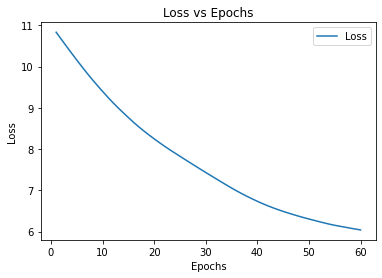

In [30]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_loss_list, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

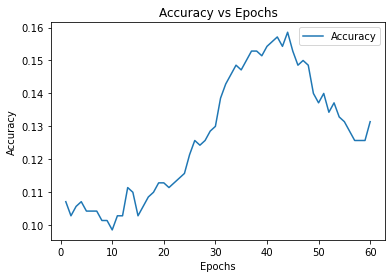

In [31]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, train_accuracy_list, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()